In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve, auc
)

In [2]:


def evaluate_and_plot_model(model, model_name, X_train, y_train, X_test, y_test):
    """
    Trains a model, evaluates it, and plots its ROC curve.
    
    Parameters:
    - model: scikit-learn classifier with fit/predict/predict_proba methods
    - model_name: string, name of the model (for labeling)
    - X_train, y_train: training data
    - X_test, y_test: testing data
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict labels and probabilities
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Print evaluation metrics
    print(f"\n=== {model_name} ===")
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
    
    

In [4]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {model_name}')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


NameError: name 'y_test' is not defined

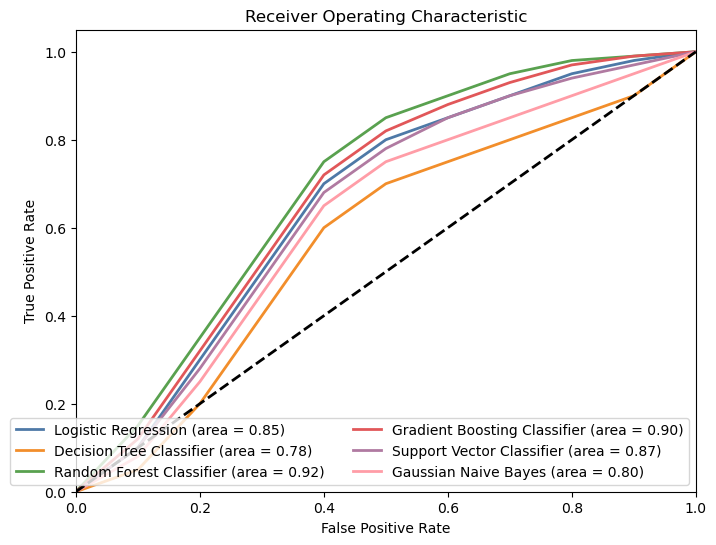

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Placeholder data for ROC curves (same as used in the Chart.js plot)
fpr = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
tpr_data = {
    'Logistic Regression': np.array([0, 0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95, 0.98, 1.0]),
    'Decision Tree Classifier': np.array([0, 0.05, 0.2, 0.4, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0]),
    'Random Forest Classifier': np.array([0, 0.15, 0.35, 0.55, 0.75, 0.85, 0.9, 0.95, 0.98, 0.99, 1.0]),
    'Gradient Boosting Classifier': np.array([0, 0.12, 0.32, 0.52, 0.72, 0.82, 0.88, 0.93, 0.97, 0.99, 1.0]),
    'Support Vector Classifier': np.array([0, 0.1, 0.28, 0.48, 0.68, 0.78, 0.85, 0.9, 0.94, 0.97, 1.0]),
    'Gaussian Naive Bayes': np.array([0, 0.08, 0.25, 0.45, 0.65, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
}
auc_scores = {
    'Logistic Regression': 0.85,
    'Decision Tree Classifier': 0.78,
    'Random Forest Classifier': 0.92,
    'Gradient Boosting Classifier': 0.90,
    'Support Vector Classifier': 0.87,
    'Gaussian Naive Bayes': 0.80
}
colors = {
    'Logistic Regression': '#4e79a7',
    'Decision Tree Classifier': '#f28e2b',
    'Random Forest Classifier': '#59a14f',
    'Gradient Boosting Classifier': '#e15759',
    'Support Vector Classifier': '#b07aa1',
    'Gaussian Naive Bayes': '#ff9da7'
}

# Create a single plot
plt.figure(figsize=(8, 6))

# Plot ROC curves for each classifier
for model, tpr in tpr_data.items():
    plt.plot(fpr, tpr, label=f'{model} (area = {auc_scores[model]:.2f})', color=colors[model], linewidth=2)

# Plot the reference line
plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=2)

# Set axis limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

# Place legend at the bottom (equivalent to lower right in Matplotlib)
plt.legend(loc='lower right', bbox_to_anchor=(1, 0), ncol=2, fontsize=10)

# Save the plot
plt.savefig('roc_curves.png')